In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..') # path to preprocessing from here

from preprocessing.scripts import argParser
from preprocessing.src import Plots
from preprocessing.src import Statistics
from preprocessing.Stimuli.FreeViewing.ATV import TrialReader

In [3]:
# Some configuration variables
dataDir = "/data/perlman/moochie/user_data/SchneiderClayton/studyData/ATV_LCBD_copy_120821/data"
# episode = 1 # which episode number (1-3) we are dealing with
TR = 0.8 # this is because we'll want to have it sampled at the TR for later (s)
min_episode_samples = 900 # some recordings are shorter than others, and we don't want to include them...
ex_subs = [] # any subjects to not include in the dataset
participant_num_len = 3 # default length of participant numbers

In [4]:
# build a list of all the applicable ATV data files
fnames = [join(dataDir, fname) for fname in os.listdir(dataDir)\
    if os.path.basename(fname)[:participant_num_len] not in ex_subs]

dataset = []
print("Loading ATV files as TimeSeries objects:")
print("==========")
for fpath in tqdm(fnames):
    try:
        # for each filepath in the list, run an ATV.TrialReader builder
        # add each src.TimeSeries object generated from the TrialReader to
        # the dataset list
        for ts in TrialReader(fpath).ratingsSeries:
            dataset.append(ts)
    except:
        print("Failure to read:", os.path.basename(fpath))
        pass

Loading ATV files as TimeSeries objects:


100%|██████████| 18/18 [00:30<00:00,  1.71s/it]


In [5]:
print("Preprocessing TimeSeries:")
print("==========")
for ts in tqdm(dataset):
    ts.fix_nan()
    ts.lag_correct()
    ts.resample(sample_rate=TR)

Preprocessing TimeSeries:


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Inspecting Lengths of Ratings in Each Episode:


100%|██████████| 3/3 [00:00<00:00, 117.42it/s]


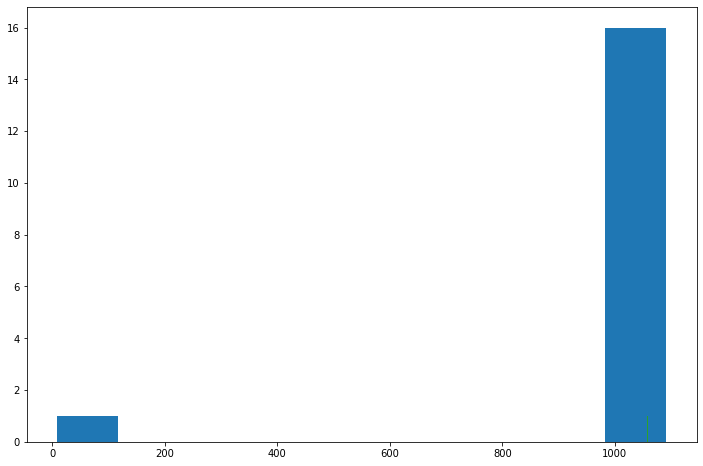

In [6]:
print("Inspecting Lengths of Ratings in Each Episode:")
print("==========")
episodes = []

for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    plt.hist([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode])

Inspecting Lengths of Ratings in Each Episode After Dropping:


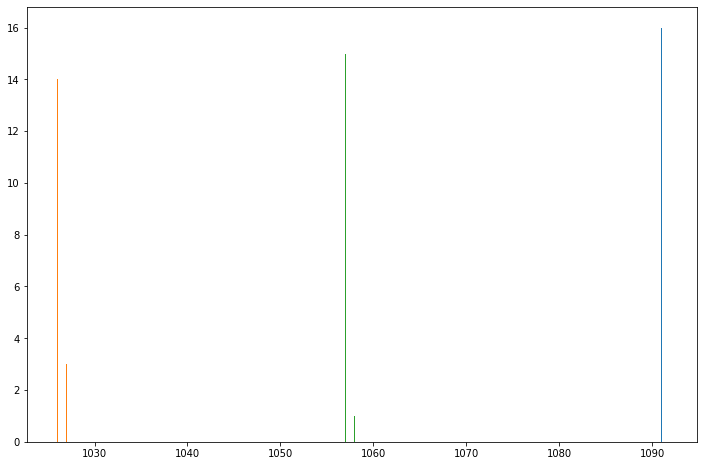

In [7]:
print("Inspecting Lengths of Ratings in Each Episode After Dropping:")
print("==========")

dataset = [ts for ts in dataset if len(ts.signal) > min_episode_samples]

for episode in episodes:
    plt.hist([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode])

In [8]:
print("Matching Lengths and Discretizing with Averages of Each:")
print("==========")

episodes = []
d_dataset = {}
d_avgs = {}
# truncate each batch of runs with the same episode to the length of the
# shortest trial in the batch
for episode in tqdm(list(set([ts.meta['episode'] for ts in dataset]))):
    episodes.append(episode)
    ep_min = min([len(ts.signal) for ts in dataset\
        if ts.meta['episode']==episode and len(ts.signal) > min_episode_samples])
    for ts in [ts for ts in dataset if ts.meta['episode']==episode]:
        ts.signal = ts.signal[:ep_min]
        ts.time = ts.time[:ep_min]
        
    # discretize the dataset to a dict with entry for each episode
    d_dataset[episode] = [ts for ts in dataset if ts.meta['episode'] == episode]
    # make averages (discretized) of each episode's runs (same struc as d_dataset)
    d_avgs[episode] = np.average(np.array([ts.signal for ts in d_dataset[episode]]), axis=0)

Matching Lengths and Discretizing with Averages of Each:


100%|██████████| 3/3 [00:00<00:00, 2916.76it/s]


In [9]:
# just view the structure of this object
print(d_dataset)
print(d_avgs)

{0: [<preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a38fb00>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a38fda0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a38f160>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a38ff28>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a38f7b8>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b22e8>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b2400>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b2278>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b26a0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b2748>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b2908>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b28d0>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b2940>, <preprocessing.src.TimeSeries.TimeSeries object at 0x7ff55a3b2c18>, <preprocessing.src.TimeSeries.TimeSeries ob

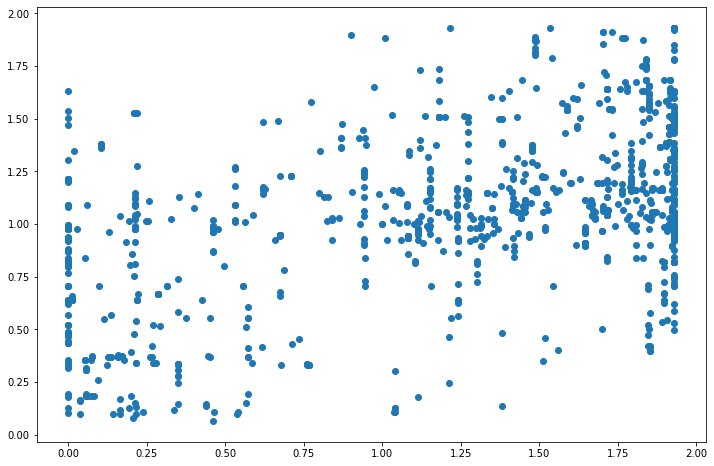

In [10]:
plt.scatter(
    d_dataset[0][0].signal,
    d_dataset[0][1].signal,)

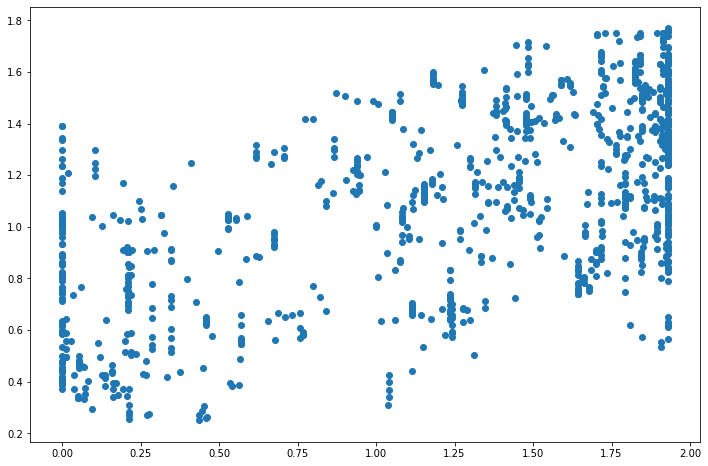

In [11]:
plt.scatter(
    d_dataset[0][0].signal,
    d_avgs[0])

In [49]:
# initialize empty array for icc values (one per timepoint)
iccs = {}

for episode in episodes:
    iccs[episode] = np.array(d_dataset[episode][0].signal.shape)

    # traverse through axis 1 / columns / timeoints
    for i, col in enumerate(np.array([ts.signal for ts in purged_dataset]).T):
        # append icc for timepoint to iccs
        iccs[episode][i] = Statistics.icc(
            np.array(col),
            icc_type='ICC(1,1)')

[array([1.        , 1.00714069, 0.99999805, 1.05151233, 0.96214346,
        1.01336779, 1.06570755, 1.25292116, 1.39936786]),
 array([1.        , 1.08118916, 1.20041033, ..., 1.32908677, 1.31328976,
        1.31034036]),
 array([1.        , 0.98657407, 1.09254415, ..., 0.75785213, 0.63514663,
        0.61758777])]

In [18]:
cmx = {}

for episode in episodes:
    # initialize empty cmatrix shape of:
    # num. runs for episode + 1 ^^ 2
    cmx[episode] = np.zeros(shape=(len(d_dataset[episode])+1, len(d_dataset[episode])+1))
    
    

In [17]:
cmatrices[0]

array([[1., 1.],
       [1., 1.]])